In [175]:
!pip install pandas numpy scikit-learn matplotlib seaborn statsmodels


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import warnings
warnings.filterwarnings('ignore')


In [177]:
df = pd.read_csv("compas-scores.csv")

# Delete rows with missing values
df = df.dropna(subset=["race", "sex", "age", "priors_count", "c_charge_degree", "decile_score"])

# Take only important features
features = ["age", "sex", "race", "priors_count", "juv_fel_count", "juv_misd_count", "c_charge_degree"]
target = "decile_score"  # Target - compas score
# For c_charge_degree: F - Felony (рус.ан. "Тяжкое", M - Misdemeanor (рус.ан. "Средняя тяжость"), O - Other
X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess data
numeric_features = ["age", "priors_count", "juv_fel_count", "juv_misd_count"]
categorical_features = ["sex", "race", "c_charge_degree"]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Optimized model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=7,
        min_samples_leaf=5,
        random_state=42))
])

# Model training
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Check on real sample
high_risk_idx = y_test[y_test > 7].index[0]
sample = X_test.loc[[high_risk_idx]]
print(f"\nReal decile_score: {y_test.loc[high_risk_idx]}")
print(f"Predicted: {model.predict(sample)[0]:.2f}")

MAE: 1.67
RMSE: 2.11

Real decile_score: 9
Predicted: 5.39


In [178]:
# Analyze importance of different parameters
importances = model.named_steps['regressor'].feature_importances_
features = model.named_steps['preprocessor'].get_feature_names_out()
pd.Series(importances, index=features).sort_values(ascending=False)

num__age                      0.447778
num__priors_count             0.446711
cat__race_African-American    0.050874
num__juv_fel_count            0.013764
cat__c_charge_degree_M        0.011301
cat__race_Caucasian           0.006735
num__juv_misd_count           0.004238
cat__c_charge_degree_O        0.004137
cat__race_Other               0.003599
cat__sex_Male                 0.003294
cat__sex_Female               0.003206
cat__c_charge_degree_F        0.002838
cat__race_Hispanic            0.001502
cat__race_Native American     0.000017
cat__race_Asian               0.000005
dtype: float64

In [179]:
def generate_face(pipeline, x_orig, y_target, feature_names, immutable_features=[], lambda_=0.5, max_iter=1000):
    """
    Generate conterfactual explanation with limit on immutable features (that cannot be changed)
    """
    preprocessor = pipeline.named_steps['preprocessor']
    model = pipeline.named_steps['regressor']

    # Take mask of immutable features
    feature_names_transformed = preprocessor.get_feature_names_out()
    immutable_mask = np.zeros(len(feature_names_transformed), dtype=bool)
    for i, name in enumerate(feature_names_transformed):
        if any(imm in name for imm in immutable_features):
            immutable_mask[i] = True

    # Initialization
    x_cf = preprocessor.transform(pd.DataFrame([x_orig], columns=feature_names)).astype(float)

    for _ in range(max_iter):
        # Check convergence
        y_pred = model.predict(x_cf)[0]
        if abs(y_pred - y_target) < 0.1:
            break

        # Gradient
        grad = np.zeros_like(x_cf)
        eps = 1
        for i in range(x_cf.shape[1]):
            if immutable_mask[i]:
                continue

            x_temp = x_cf.copy()
            x_temp[0, i] += eps
            y_temp = model.predict(x_temp)[0]
            grad[0, i] = (y_temp - y_pred) / eps

        # Update with projection
        x_cf -= lambda_ * grad
        x_cf[:, immutable_mask] = preprocessor.transform(
            pd.DataFrame([x_orig], columns=feature_names))[:, immutable_mask]

    return x_cf[0]

In [180]:
sample_idx = y_test[y_test > 7].index[0]
sample = X_test.loc[sample_idx]
print(sample)
# test_case = pd.Series({
#     'age': 30,
#     'race': 'Caucasian',
#     'sex': 'Male',
#     'priors_count': 5,
#     'juv_fel_count': 1,
#     'c_charge_degree': 'F'
# }, name='test')
# sample = test_case

original_pred = pipeline.predict(pd.DataFrame([sample]))[0]
print("Original prediction:", original_pred)

target_value = max(original_pred - 1, 1)
# target_value = original_pred
cf_vector = generate_face(pipeline, sample, target_value, X.columns.tolist(), immutable_features=['age'])

# Transform original sample
x_orig_proc = pipeline.named_steps['preprocessor'].transform(pd.DataFrame([sample], columns=X.columns))

# Difference
delta = cf_vector - x_orig_proc[0]
changed_indices = np.where(np.abs(delta) > 1e-3)[0]

# Get names of transformed features
feature_names_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Features transformed:")
for idx in changed_indices:
    print(f"{feature_names_transformed[idx]}: {x_orig_proc[0][idx]:.3f} → {cf_vector[idx]:.3f}")


age                              24
sex                            Male
race               African-American
priors_count                      0
juv_fel_count                     0
juv_misd_count                    0
c_charge_degree                   O
Name: 10113, dtype: object
Original prediction: 6.333845238095239
Features transformed:
num__priors_count: -0.660 → -3.174
cat__race_Asian: 0.000 → 1.176
cat__race_Caucasian: 0.000 → 0.783
cat__race_Hispanic: 0.000 → 0.521
cat__race_Native American: 0.000 → -0.531
cat__race_Other: 0.000 → 1.914
cat__c_charge_degree_M: 0.000 → 0.514


In [181]:
# Example: lock all features except race
immutable_features = ["age", "priors_count", "c_charge_degree", "sex"]
original_pred = pipeline.predict(pd.DataFrame([sample]))[0]
cf = generate_face(
    pipeline,
    sample,
    max(original_pred - 1, 1),
    X.columns.tolist(),
    immutable_features 
)
# Transform original sample
x_orig_proc = pipeline.named_steps['preprocessor'].transform(pd.DataFrame([sample], columns=X.columns))

# Difference
delta = cf - x_orig_proc[0]
changed_indices = np.where(np.abs(delta) > 1e-3)[0]

# Get names of transformed features
feature_names_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Features transformed:")
for idx in changed_indices:
    print(f"{feature_names_transformed[idx]}: {x_orig_proc[0][idx]:.3f} → {cf[idx]:.3f}")

Features transformed:
cat__race_Asian: 0.000 → 1.176
cat__race_Caucasian: 0.000 → 0.783
cat__race_Hispanic: 0.000 → -0.527
cat__race_Native American: 0.000 → -1.050
cat__race_Other: 0.000 → 1.914


In [182]:
# Example: lock all features except African-American race
sample = X_test[X_test["race"] == "African-American"].iloc[0]
immutable_features = ["race"]
original_pred = pipeline.predict(pd.DataFrame([sample]))[0]
cf = generate_face(
    pipeline,
    sample,
    max(original_pred - 1, 1),
    X.columns.tolist(),
    immutable_features 
)
# Transform original sample
x_orig_proc = pipeline.named_steps['preprocessor'].transform(pd.DataFrame([sample], columns=X.columns))

# Difference
delta = cf - x_orig_proc[0]
changed_indices = np.where(np.abs(delta) > 1e-3)[0]

# Get names of transformed features
feature_names_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Transformed features:")
for idx in changed_indices:
    print(f"{feature_names_transformed[idx]}: {x_orig_proc[0][idx]:.3f} → {cf[idx]:.3f}")

Transformed features:
num__age: 1.415 → 1.533
num__priors_count: -0.232 → -3.196
cat__c_charge_degree_M: 0.000 → 0.683
cat__c_charge_degree_O: 0.000 → -0.778


In [183]:
# Now, for the same sample change only race from African-American to Caucasian
sample["race"] = "Caucasian"
immutable_features = ["race"]
original_pred = pipeline.predict(pd.DataFrame([sample]))[0]
cf = generate_face(
    pipeline,
    sample,
    max(original_pred - 1, 1),
    X.columns.tolist(),
    immutable_features 
)
# Transform original sample
x_orig_proc = pipeline.named_steps['preprocessor'].transform(pd.DataFrame([sample], columns=X.columns))

# Difference
delta = cf - x_orig_proc[0]
changed_indices = np.where(np.abs(delta) > 1e-3)[0]

# Get names of transformed features
feature_names_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Features transformed:")
for idx in changed_indices:
    print(f"{feature_names_transformed[idx]}: {x_orig_proc[0][idx]:.3f} → {cf[idx]:.3f}")

Features transformed:
num__age: 1.415 → 2.681
num__priors_count: -0.232 → -1.631
cat__c_charge_degree_M: 0.000 → 1.433
cat__c_charge_degree_O: 0.000 → 0.096


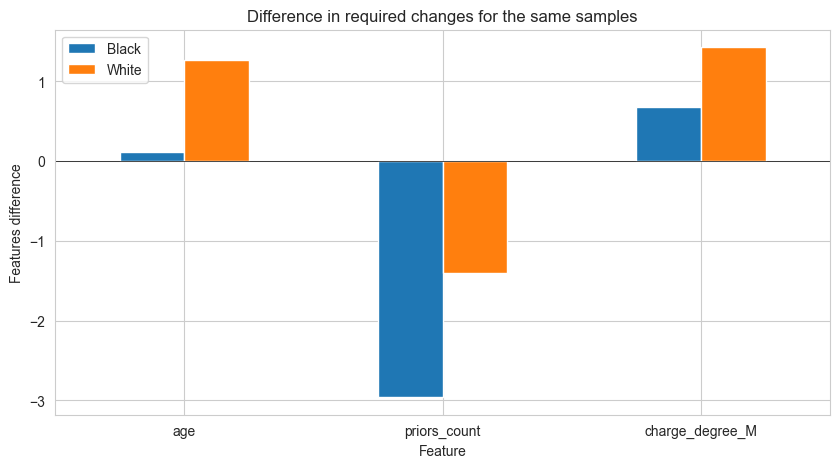

In [184]:
import matplotlib.pyplot as plt

changes = pd.DataFrame({
    'Feature': ['age', 'priors_count', 'charge_degree_M'],
    'Black': [0.12, -2.96, 0.68],
    'White': [1.27, -1.40, 1.43]
}).set_index('Feature')

changes.plot(kind='bar', figsize=(10, 5))
plt.axhline(0, color='black', linewidth=0.5)
plt.title("Difference in required changes for the same samples")
plt.ylabel("Features difference")
plt.xticks(rotation=0)
plt.savefig("difference_in_required_changes_for_same_samples.png")
plt.show()

Mean prediction among races:
race
African-American    5.326640
Asian               3.268901
Caucasian           3.587028
Hispanic            3.143077
Native American     4.617124
Other               2.745923
Name: prediction, dtype: float64

Mean prediction among sexes:
sex
Female    4.121723
Male      4.415251
Name: prediction, dtype: float64

Mean prediction among age groups:
age_group
<25      5.755973
25-45    4.322022
45-65    2.820731
65+      1.887918
Name: prediction, dtype: float64


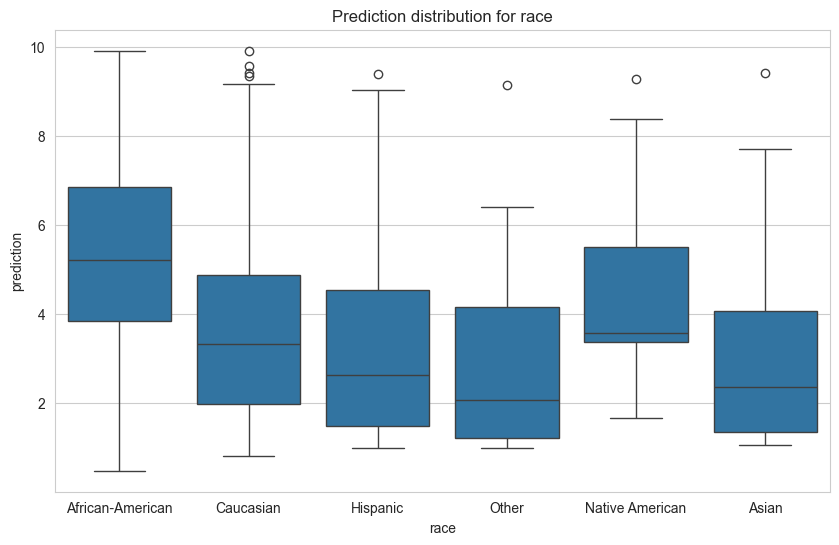

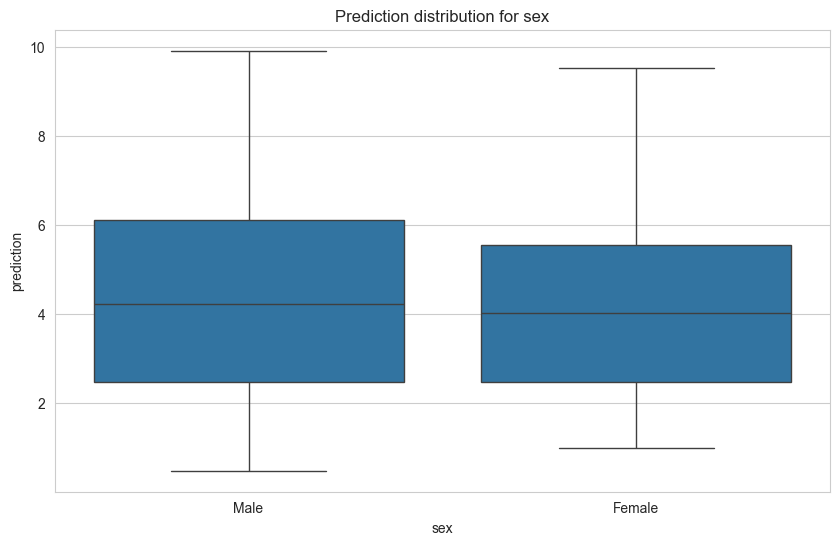


Comparison of the mean prediction for the same charge_degree:
race             African-American     Asian  Caucasian  Hispanic  \
c_charge_degree                                                    
F                        5.656502  3.332869   3.977374  3.756948   
M                        4.694451  3.399621   3.036810  2.544644   
O                        4.789182  2.365000   3.289703  2.926896   

race             Native American     Other  
c_charge_degree                             
F                       5.302671  2.989458  
M                       3.586784  2.323282  
O                       4.280413  2.449263  

Numeral features correlations with prediction:
prediction        1.000000
priors_count      0.554450
juv_misd_count    0.261882
juv_fel_count     0.206627
age              -0.500942
Name: prediction, dtype: float64


In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add model predictions X_test
X_test_copy = X_test.copy()
X_test_copy['prediction'] = pipeline.predict(X_test)

# Distributions of predictions among races
print("Mean prediction among races:")
print(X_test_copy.groupby('race')['prediction'].mean())

# Distribution among sexes
print("\nMean prediction among sexes:")
print(X_test_copy.groupby('sex')['prediction'].mean())

# Transform age into categories
X_test_copy['age_group'] = pd.cut(X_test_copy['age'], bins=[0, 25, 45, 65, 100], labels=['<25', '25-45', '45-65', '65+'])
print("\nMean prediction among age groups:")
print(X_test_copy.groupby('age_group')['prediction'].mean())

# Distributions visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='race', y='prediction', data=X_test_copy)
plt.title("Prediction distribution for race")
plt.savefig("prediction_distribution_race.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='prediction', data=X_test_copy)
plt.title("Prediction distribution for sex")
plt.savefig("prediction_distribution_sex.png")

plt.show()

# Predictions comparison with the same charge degree
print("\nComparison of the mean prediction for the same charge_degree:")
print(X_test_copy.groupby(['c_charge_degree', 'race'])['prediction'].mean().unstack())

# Numeral features correlations with prediction
numeric_features = X_test_copy.select_dtypes(include=[np.number])
print("\nNumeral features correlations with prediction:")
print(numeric_features.corr()['prediction'].sort_values(ascending=False))



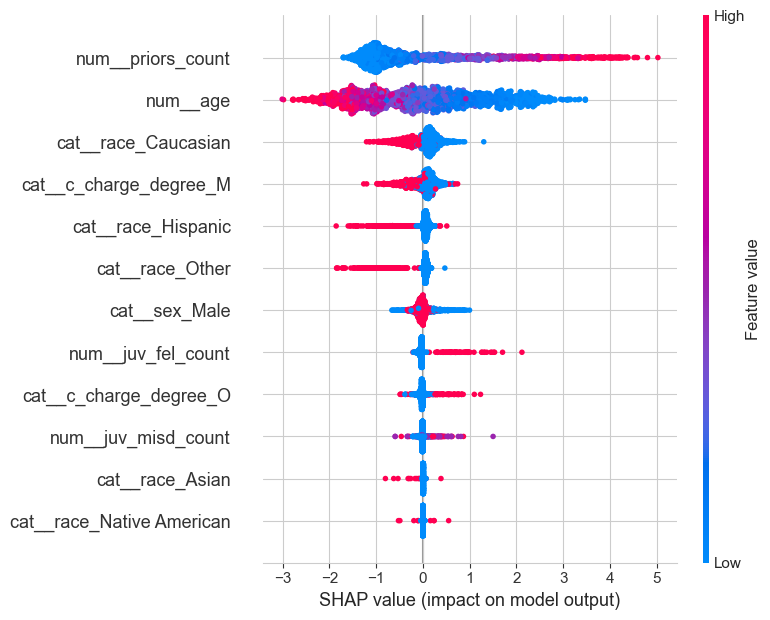

In [186]:
import shap

# Use shap explainer for pipeline
explainer = shap.TreeExplainer(pipeline.named_steps['regressor'])
preprocessed = pipeline.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(preprocessed)

# Summary plot
fig = plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, preprocessed,
                  feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out())

# Save to file
fig.savefig('shap_summary.png', bbox_inches='tight', dpi=300)
plt.close(fig)

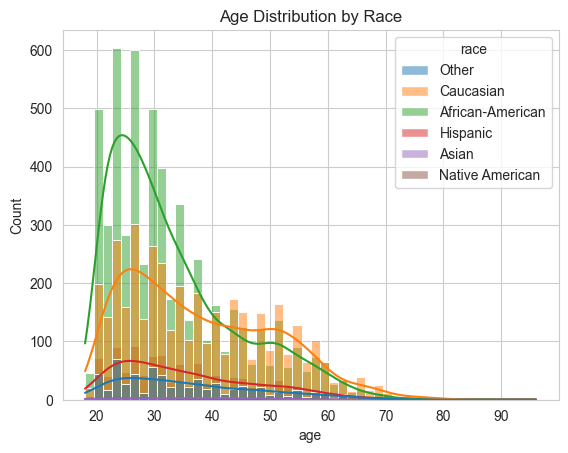

In [187]:
sns.histplot(data=df, x='age', hue='race', kde=True)
plt.title("Age Distribution by Race")
plt.savefig('age_distribution_by_race.png', bbox_inches='tight', dpi=300)
plt.show()

Mean scores for races and age groups:
                      mean                                                \
race      African-American     Asian Caucasian  Hispanic Native American   
age_group                                                                  
18-25             6.092567  4.625000  5.202144  4.960199        5.714286   
26-35             5.335147  2.933333  4.085233  3.428058        4.444444   
36-45             4.522029  2.000000  3.037791  2.335260        4.166667   
46+               3.877086  1.800000  2.090808  1.678788        3.000000   

                                 std                                \
race          Other African-American     Asian Caucasian  Hispanic   
age_group                                                            
18-25      4.641791         2.458324  2.722263  2.363227  2.459351   
26-35      2.935135         2.878368  2.576450  2.501323  2.465693   
36-45      1.782946         2.947601  2.211083  2.309091  2.100048   
46+      

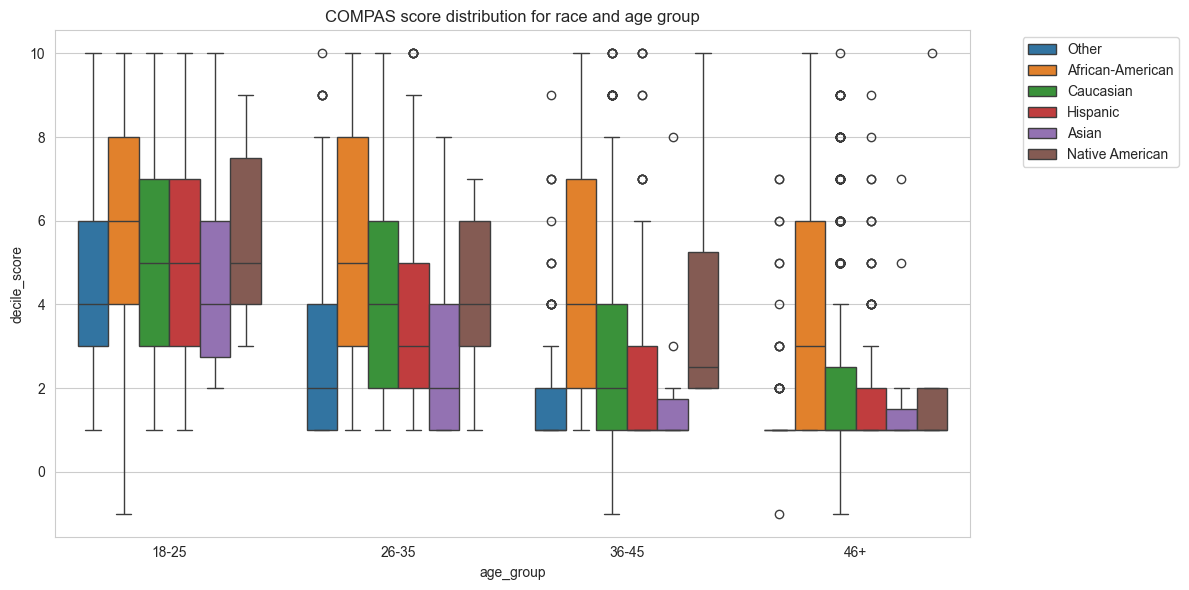


Age 46+:
African-American vs Caucasian: p-value = 0.0000
❗Statistically significant difference

Age 26-35:
African-American vs Caucasian: p-value = 0.0000
❗Statistically significant difference

Age 18-25:
African-American vs Caucasian: p-value = 0.0000
❗Statistically significant difference

Age 36-45:
African-American vs Caucasian: p-value = 0.0000
❗Statistically significant difference


In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("compas-scores.csv")

df = df[
    (df['days_b_screening_arrest'].between(-30, 30)) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'].isin(['M','F']))
    ].copy()

# Make age groups
df['age_group'] = pd.cut(df['age'],
                         bins=[0, 25, 35, 45, 100],
                         labels=['18-25', '26-35', '36-45', '46+'])

# Decile score analysis among races and age groups
race_age_stats = df.groupby(['race', 'age_group'])['decile_score'].agg(['mean', 'std', 'count'])
print("Mean scores for races and age groups:")
print(race_age_stats.unstack('race'))

# Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='decile_score', hue='race', data=df)
plt.title("COMPAS score distribution for race and age group")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("compas_score_race_and_age.png")
plt.show()

# Statistical difference check (t-test for African-Americans and Caucasians)
for age_group in df['age_group'].unique():
    black_scores = df[(df['race'] == 'African-American') & (df['age_group'] == age_group)]['decile_score']
    white_scores = df[(df['race'] == 'Caucasian') & (df['age_group'] == age_group)]['decile_score']

    t_stat, p_value = stats.ttest_ind(black_scores, white_scores, equal_var=False)
    print(f"\nAge {age_group}:")
    print(f"African-American vs Caucasian: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("❗Statistically significant difference")
    else:
        print("Statistically insignificant difference")

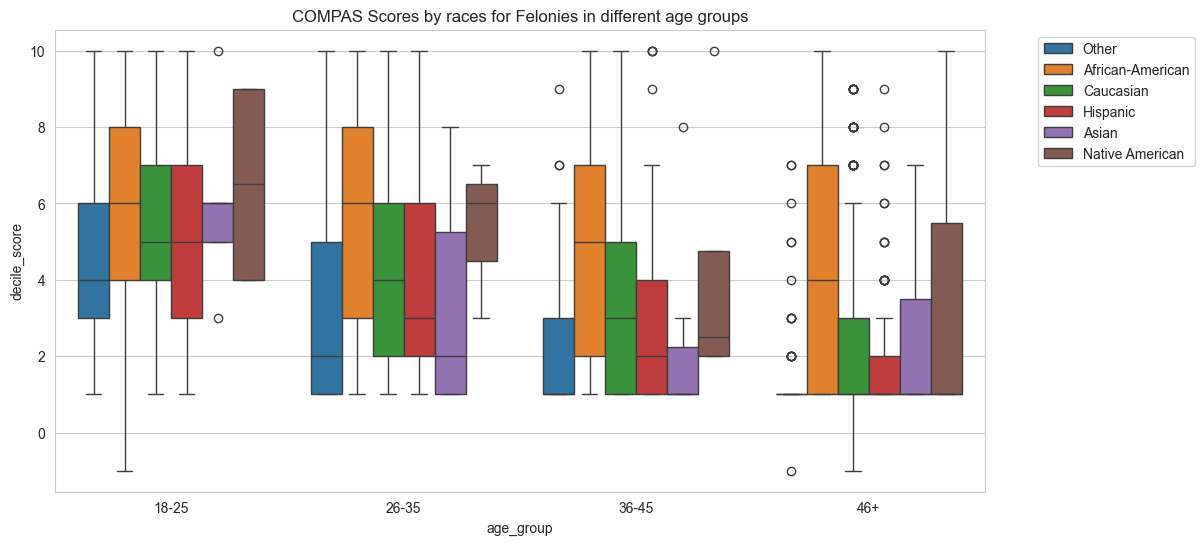

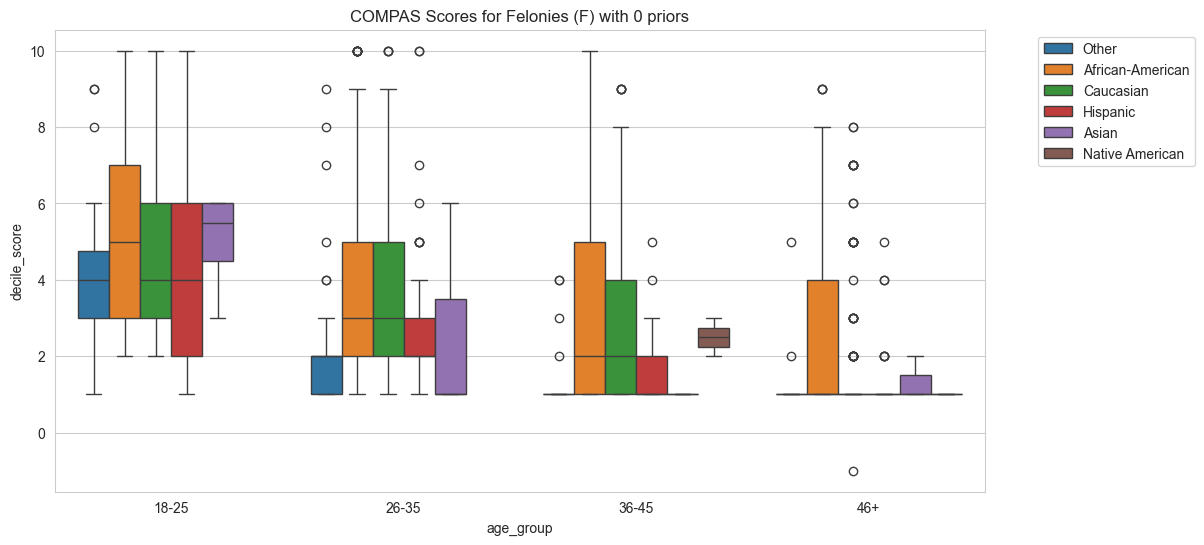

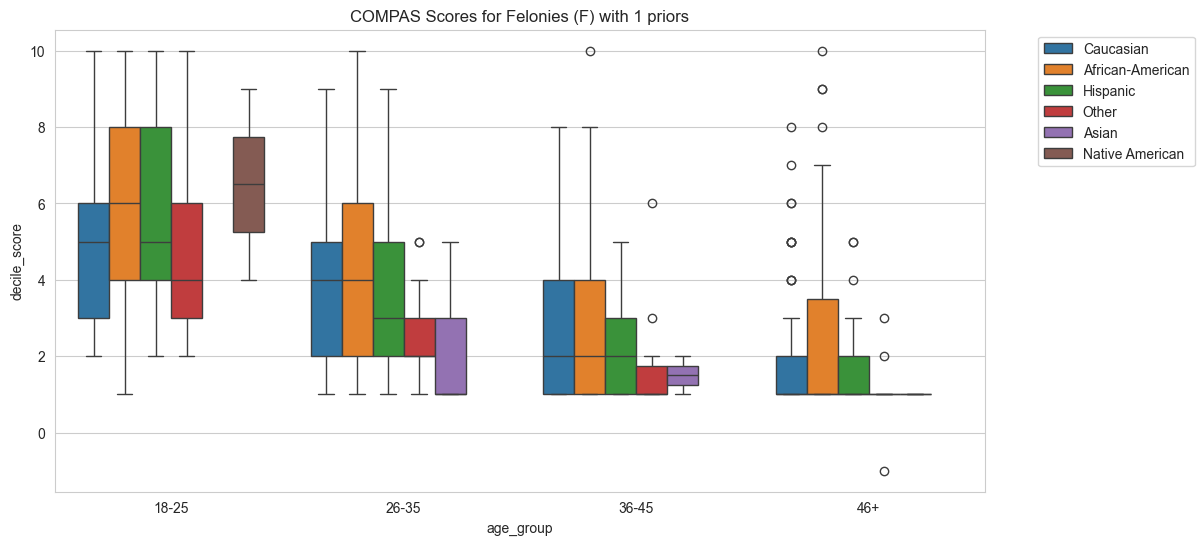

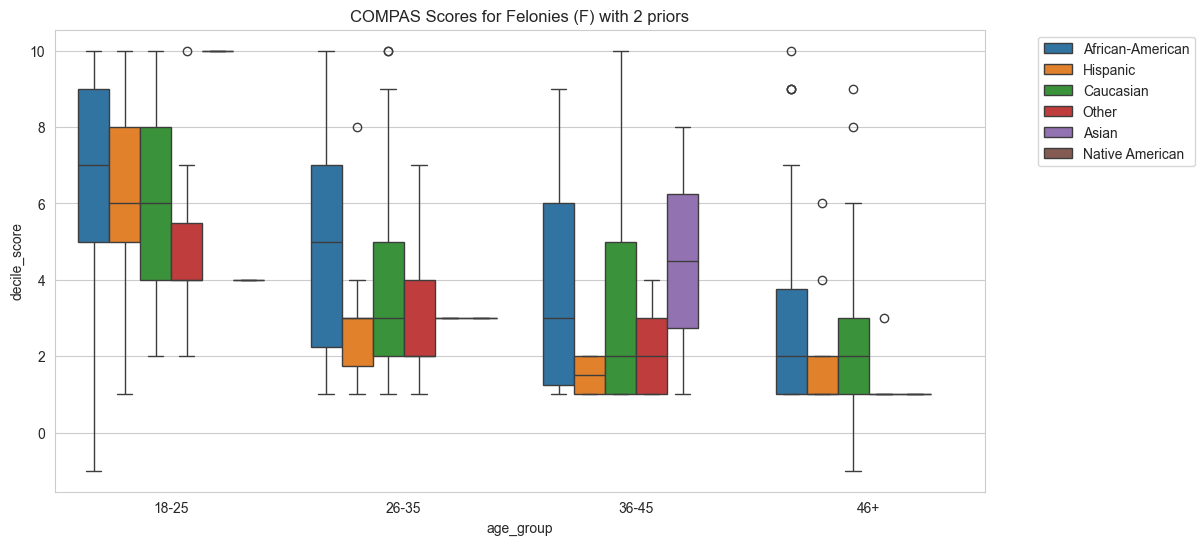

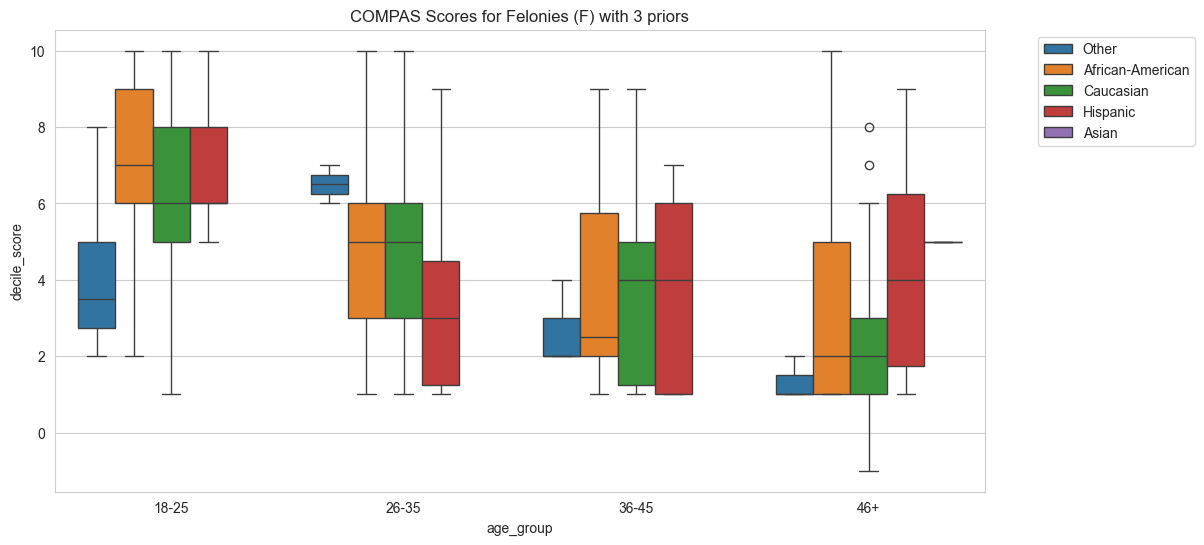

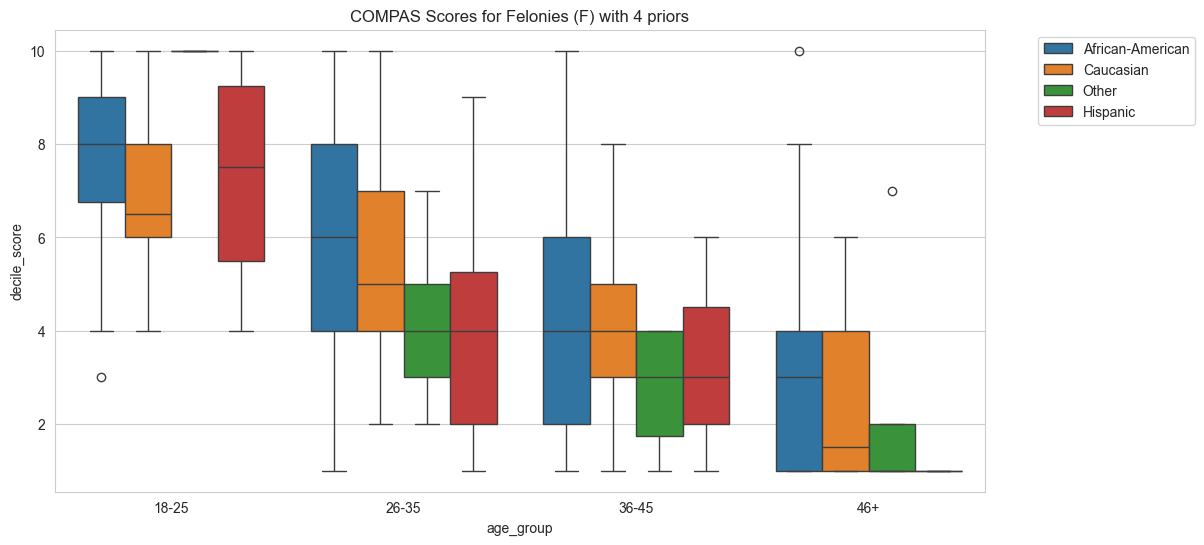

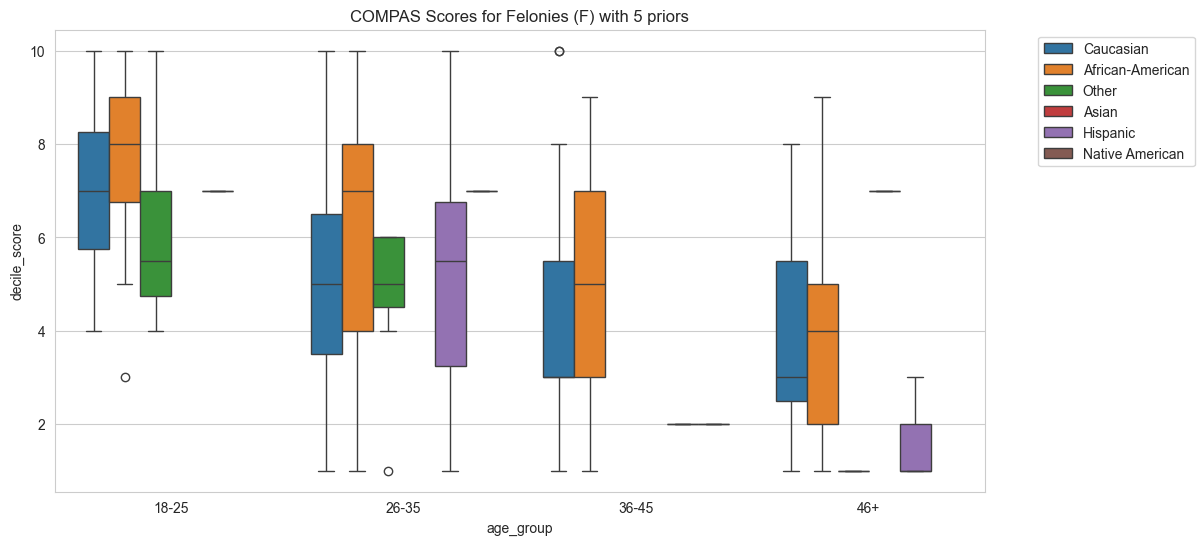

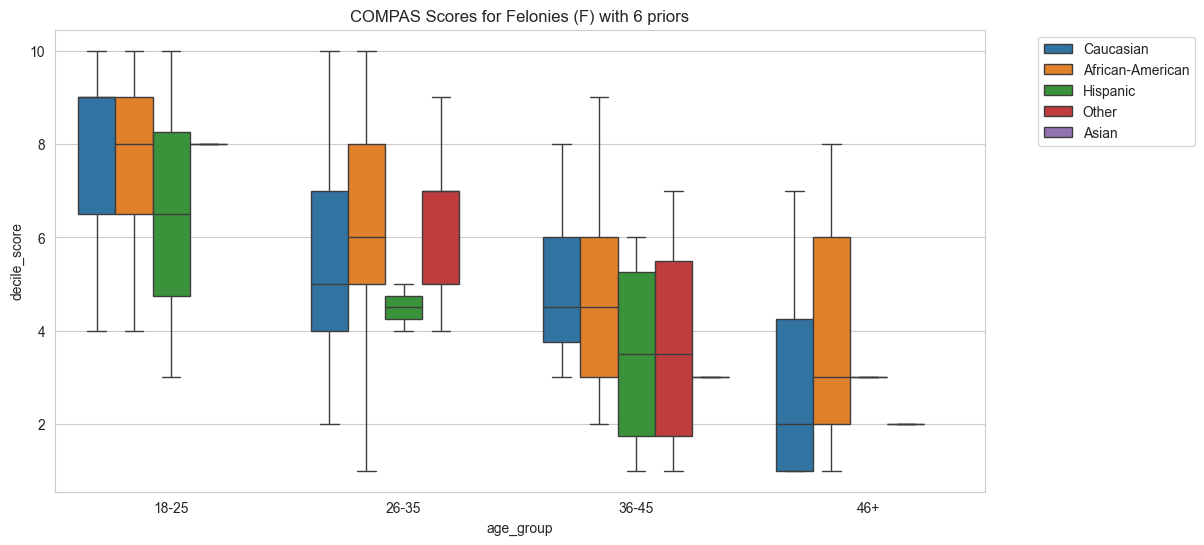

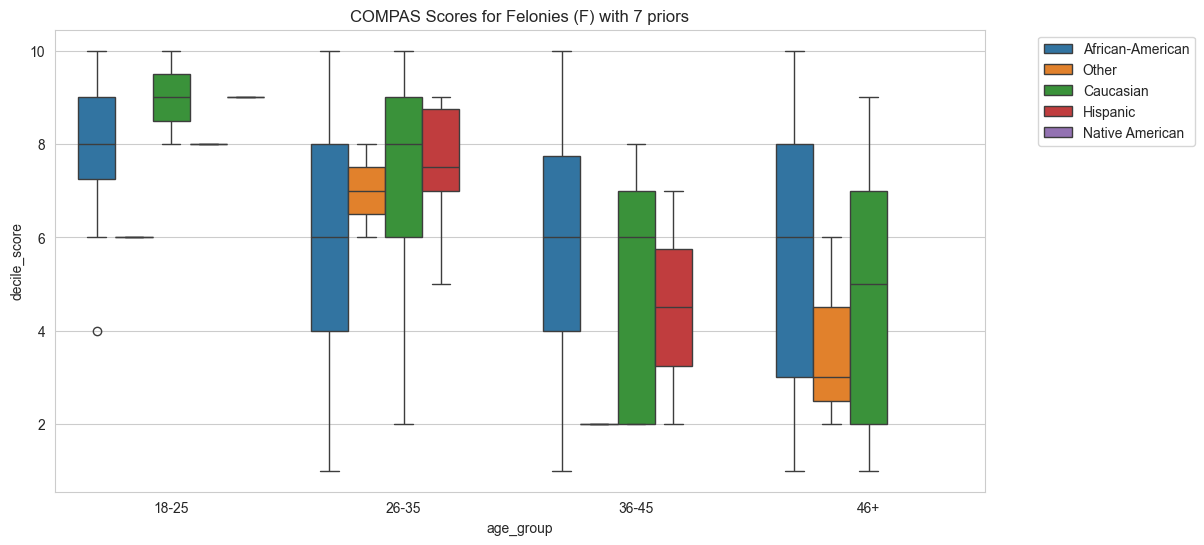

Mean scores for felonies without priors:
race       African-American     Asian  Caucasian  Hispanic  Native American  \
age_group                                                                     
18-25              5.418719  5.000000   4.810256  4.250000              NaN   
26-35              3.789256  2.666667   3.524752  2.777778              NaN   
36-45              3.188119  1.000000   2.637931  1.620690              2.5   
46+                2.486842  1.333333   1.794521  1.424242              1.0   

race          Other  
age_group            
18-25      3.826087  
26-35      2.166667  
36-45      1.346154  
46+        1.142857  


In [189]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("compas-scores.csv")

df = df[
    (df['days_b_screening_arrest'].between(-30, 30)) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'].isin(['M','F']))
    ].copy()

# Make age groups
df['age_group'] = pd.cut(df['age'],
                         bins=[0, 25, 35, 45, 100],
                         labels=['18-25', '26-35', '36-45', '46+'])

# 1. Age and charge degree analysis
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='age_group',
    y='decile_score',
    hue='race',
    data=df[df['c_charge_degree'] == 'F']
)
plt.title('COMPAS Scores by races for Felonies in different age groups')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("compas_scores_races_felonies.png", bbox_extra_artists=[plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')], bbox_inches='tight')
plt.show()

# 2. Analysis with filtration by priors_count
for priors in [0, 1, 2, 3, 4, 5, 6, 7]:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='age_group',
        y='decile_score',
        hue='race',
        data=df[
            (df['c_charge_degree'] == 'F') &
            (df['priors_count'] == priors)
            ]
    )
    plt.title(f'COMPAS Scores for Felonies (F) with {priors} priors')
    plt.savefig(f"compas_scores_races_felonies_{priors}_priors.png", bbox_extra_artists=[plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')], bbox_inches='tight')
    plt.show()

# 3. Comparison of mean values
comparison = df.groupby(['age_group', 'c_charge_degree', 'priors_count', 'race'])['decile_score'] \
    .agg(['mean', 'count']) \
    .unstack('race') \
    .sort_index()

# Output table for felonies with 0 priors
print("Mean scores for felonies without priors:")
print(comparison.loc[:, 'mean'].xs(('F', 0), level=('c_charge_degree', 'priors_count')))

priors_statistics by race and age::
                            mean  median   std  count
race             age_group                           
African-American 18-25      1.67     1.0  2.48   1424
                 26-35      4.61     3.0  5.23   1838
                 36-45      5.46     3.0  6.46    749
                 46+        5.97     3.0  6.85    659
Asian            18-25      0.38     0.0  0.74      8
                 26-35      1.47     0.0  2.61     15
                 36-45      1.20     0.5  1.87     10
                 46+        1.00     0.0  1.46     15
Caucasian        18-25      1.38     1.0  2.12    653
                 26-35      2.28     1.0  3.24   1009
                 36-45      2.52     1.0  3.68    688
                 46+        2.26     1.0  4.19    903
Hispanic         18-25      1.23     0.0  2.11    200
                 26-35      2.17     1.0  3.52    278
                 36-45      2.24     1.0  4.28    173
                 46+        1.46     1.0  2.91

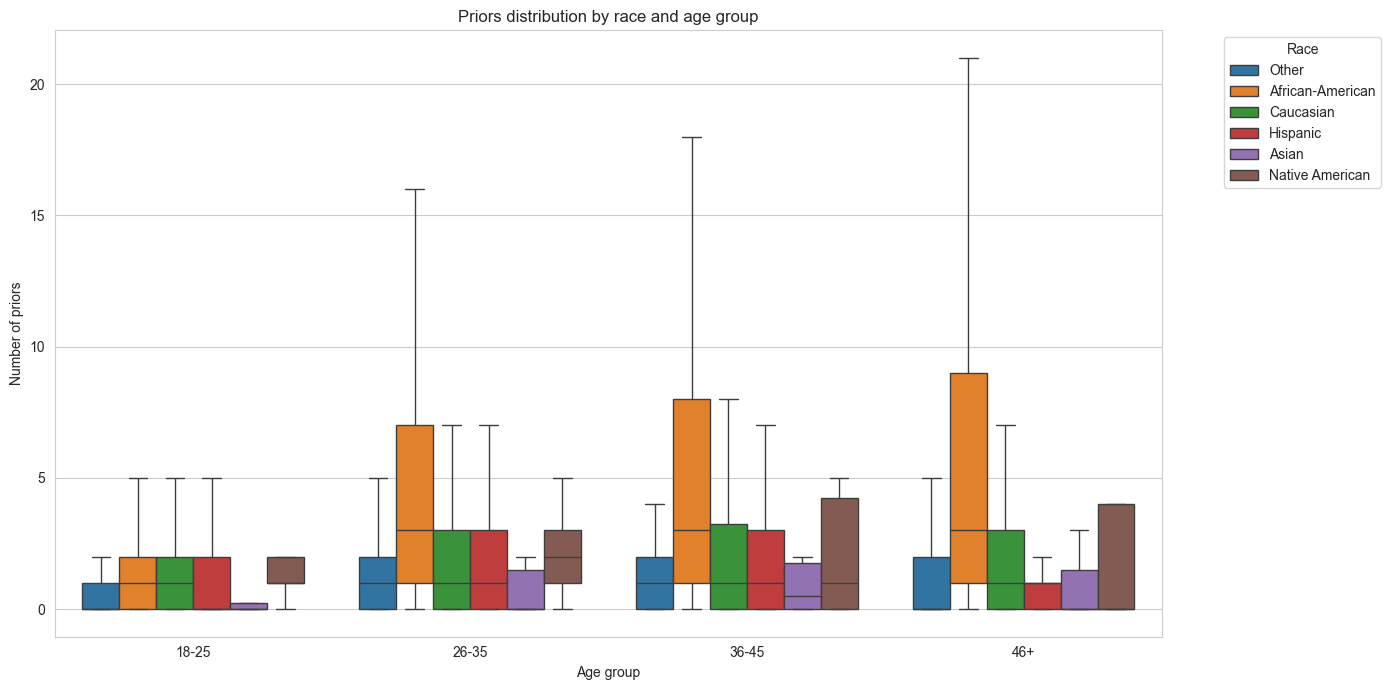


Statistically significant difference:
Data is not normally distributed:
Kruskal-Wallis: p-value = 0.0000

Pairwise comparisons:
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------------
African-American_18-25 African-American_26-35   2.9431    0.0   2.3829  3.5032   True
African-American_18-25 African-American_36-45   3.7846    0.0   3.0684  4.5008   True
African-American_18-25   African-American_46+    4.299    0.0   3.5515  5.0465   True
African-American_18-25   African-American_nan   1.3294    1.0  -9.8981 12.5568  False
African-American_18-25            Asian_18-25  -1.2956    1.0  -6.9212  4.3299  False
African-American_18-25            Asian_26-35   -0.204    1.0  -4.3223  3.9143  False
African-American_18-25            Asian_36-45  -0.4706    1.0  -5.5058  4.5645  False
African-Ame

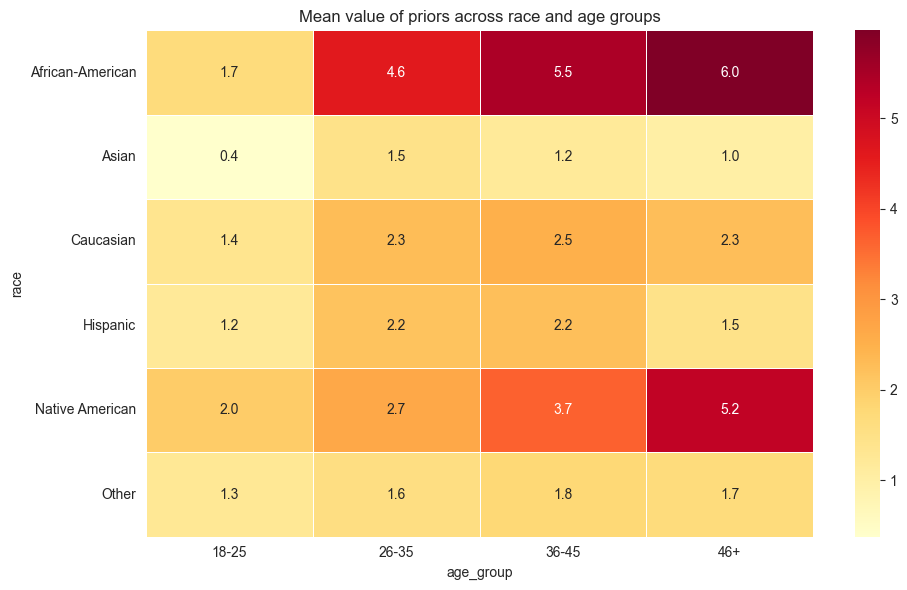

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv("compas-scores.csv")
df = df[
    (df['days_b_screening_arrest'].between(-30, 30)) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'].isin(['M','F']))
    ].copy()


df['age_group'] = pd.cut(df['age'],
                         bins=[18, 25, 35, 45, 100],
                         labels=['18-25', '26-35', '36-45', '46+'])


priors_stats = df.groupby(['race', 'age_group'])['priors_count'].agg(
    ['mean', 'median', 'std', 'count']
).round(2)
print("priors_statistics by race and age::")
print(priors_stats)


plt.figure(figsize=(14, 7))
sns.boxplot(
    x='age_group',
    y='priors_count',
    hue='race',
    data=df,
    showfliers=False 
)
plt.title('Priors distribution by race and age group')
plt.ylabel('Number of priors')
plt.xlabel('Age group')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('priors_by_race_age.png', bbox_inches='tight', dpi=300)
plt.show()


print("\nStatistically significant difference:")

# Data prepare for ANOVA
groups = []
for race in df['race'].unique():
    for age in df['age_group'].unique():
        groups.append(df[(df['race'] == race) &
                         (df['age_group'] == age)]['priors_count'].values)

# Shapiro-Wilk test
normality = all(stats.shapiro(group)[1] > 0.05 for group in groups if len(group) > 3)
print(f"Data {'is normally distributed' if normality else 'is not normally distributed'}:")

# ANOVA or Kruskal-Wallis
if normality and len(groups) > 1:
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA: p-value = {p_val:.4f}")
else:
    h_val, p_val = stats.kruskal(*[group for group in groups if len(group) > 0])
    print(f"Kruskal-Wallis: p-value = {p_val:.4f}")

# Post Hoc for all pairs

tukey = pairwise_tukeyhsd(
    endog=df['priors_count'].dropna(),
    groups=df['race'] + "_" + df['age_group'].astype(str),
    alpha=0.05
)
print("\nPairwise comparisons:")
print(tukey.summary())

# 4. Heatmap of mean values
pivot_table = df.pivot_table(
    values='priors_count',
    index='race',
    columns='age_group',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=.5)
plt.title('Mean value of priors across race and age groups')
plt.tight_layout()
plt.savefig('priors_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()